# Connect to google account

In [2]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [3]:
# 코렙 한글깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,852 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123597 files and dire

# Global Variables

In [4]:
import os
import numpy as np
import random
import torch

def reset_seeds(seed=500):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
  np.random.seed(seed)
  torch.manual_seed(seed) # cpu 연산 무작위 고정
  torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
  torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

In [5]:
import easydict
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/data/MyDrive/AI_study/1. Machine Learning/3. Supervised Learning/original data/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_0903_2.csv'
args.save_results = args.default_path+"result/model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 50 # 위의 셀에서 고정 시킴
args.results = []

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [7]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [8]:
pd.read_csv(args.default_submission_csv).shape

(393, 2)

In [9]:
ori_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [10]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [11]:
ori_train['passengerid'].nunique(), ori_train.shape[0]

(916, 916)

In [12]:
ori_train.drop('passengerid', axis=1, inplace=True)
ori_train.head()

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [13]:
ori_test.set_index(['passengerid'], inplace=True)
print(f'{ori_test.shape}')
ori_test.head()

(393, 10)


,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q
919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S
920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


# train_test_split

In [14]:
new_survived = pd.Categorical(ori_train["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])

new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
y = ori_train['survived']
X = ori_train.drop(['survived'], axis=1)

In [17]:
reset_seeds()
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=ori_train['survived'])

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((732, 10), (184, 10), (732,), (184,))

# Base ModelV0

In [18]:
train = X_tr.copy()
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((732, 10), (184, 10), (393, 10))

## Data Preprocessing

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 12 to 731
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    732 non-null    int64  
 1   name      732 non-null    object 
 2   gender    732 non-null    object 
 3   age       587 non-null    float64
 4   sibsp     732 non-null    int64  
 5   parch     732 non-null    int64  
 6   ticket    732 non-null    object 
 7   fare      732 non-null    float64
 8   cabin     166 non-null    object 
 9   embarked  731 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 62.9+ KB


In [20]:
train.drop('name', axis=1, inplace=True)
test.drop('name', axis=1, inplace=True)
ori_te.drop('name', axis=1, inplace=True)

train.drop('ticket', axis=1, inplace=True)
test.drop('ticket', axis=1, inplace=True)
ori_te.drop('ticket', axis=1, inplace=True)

train.drop('cabin', axis=1, inplace=True)
test.drop('cabin', axis=1, inplace=True)
ori_te.drop('cabin', axis=1, inplace=True)

In [21]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [22]:
num_features = ["age", "sibsp", "parch", "fare"]
cat_features = ["pclass", "gender", "embarked"]

num_transformer = Pipeline(
    steps = [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

cat_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
         ("num", num_transformer, num_features),
         ("cat", cat_transformer, cat_features)
         ]
)

In [23]:
pipe = Pipeline(
    steps = [("preporcessor", preprocessor), ("regressor", LinearRegression())]
)

In [24]:
from sklearn import set_config
set_config(display='diagram')

In [25]:
pipe.fit(X_tr, y_tr)

Pipeline(steps=[('preporcessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pclass', 'gender',
                                                   'embarked'])])),
                ('regressor', LinearRegression())])

In [26]:
from sklearn.metrics import mean_absolute_percentage_error

In [38]:
y_pred = pipe.predict(test)
y_pred, y_te

(array([ 2.35489697e-01,  1.09497854e+00, -2.49460535e-02,  1.11337027e-01,
         6.43905371e-02,  5.80102530e-02,  1.74227838e-01,  9.28093986e-01,
         1.61259892e-01,  7.80097019e-01,  1.71034731e-01,  3.08805463e-01,
         2.64154434e-01,  1.98506980e-01,  1.83424099e-02,  1.05316434e+00,
         4.10515254e-02, -1.03955571e-02,  1.03081087e+00,  8.04300590e-01,
         8.97477563e-01,  6.53786001e-02,  2.95914346e-01,  1.61259892e-01,
         7.99765872e-01,  1.37229591e-01,  1.79348336e-01,  2.41707247e-01,
         6.45093539e-01,  8.12660678e-02,  8.09391077e-02,  1.48682979e-01,
         1.06789866e-01,  8.12660678e-02,  2.04311187e-01,  9.96995031e-01,
         2.70362942e-01,  1.03567191e-01,  1.04256075e+00,  1.34036484e-01,
         9.08453901e-02,  1.03106731e+00,  1.15758283e-01,  8.06388589e-01,
         2.51286569e-01,  7.49579224e-02,  2.38235681e-01,  8.03812733e-01,
         7.46395430e-01,  1.03632603e-01,  1.21264054e-01,  9.38359828e-02,
         7.4

In [39]:
mean_absolute_percentage_error(y_pred, y_te)

1.0334105959534736

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 12 to 731
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    732 non-null    int64  
 1   name      732 non-null    object 
 2   gender    732 non-null    object 
 3   age       587 non-null    float64
 4   sibsp     732 non-null    int64  
 5   parch     732 non-null    int64  
 6   ticket    732 non-null    object 
 7   fare      732 non-null    float64
 8   cabin     166 non-null    object 
 9   embarked  731 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 62.9+ KB


drop columns

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 10) / (184, 10)
after: (732, 7) / (184, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 12 to 731
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    732 non-null    int64  
 1   gender    732 non-null    object 
 2   age       587 non-null    float64
 3   sibsp     732 non-null    int64  
 4   parch     732 non-null    int64  
 5   fare      732 non-null    float64
 6   embarked  731 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 45.8+ KB


missing value

In [ ]:
train.isnull().sum()

,0
pclass,0
gender,0
age,145
sibsp,0
parch,0
fare,0
embarked,1


In [ ]:
test.isnull().sum()

,0
pclass,0
gender,0
age,35
sibsp,0
parch,0
fare,0
embarked,0


In [ ]:
ori_te.isnull().sum()

,0
pclass,0
gender,0
age,83
sibsp,0
parch,0
fare,1
embarked,1


In [ ]:
age_median = train['age'].median()
fare_median = train['fare'].median()
embarked_mode = train['embarked'].mode().values[0]

age_median, fare_median, embarked_mode

(28.0, 14.76665, 'S')

In [ ]:
train['age'].fillna(age_median, inplace=True)
test['age'].fillna(age_median, inplace=True)
ori_te['age'].fillna(age_median, inplace=True)

train['fare'].fillna(fare_median, inplace=True)
test['fare'].fillna(fare_median, inplace=True)
ori_te['fare'].fillna(fare_median, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

data encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
train.columns

Index(['pclass', 'gender', 'age', 'sibsp', 'parch', 'fare', 'embarked'], dtype='object')

In [ ]:
enc_cols = ['gender', 'embarked']
normal_cols = list(set(train.columns) - set(enc_cols))
normal_cols

['fare', 'pclass', 'sibsp', 'age', 'parch']

In [ ]:
print(f'before: {train.shape} / {test.shape}')

enc = OneHotEncoder()
# train
tmp_tr = pd.DataFrame(
    enc.fit_transform(train[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_tr = pd.concat(
    [train[normal_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]
    , axis=1
)
# test
tmp_te = pd.DataFrame(
    enc.transform(test[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_te = pd.concat(
    [test[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)
# ori_test
tmp_te = pd.DataFrame(
    enc.transform(ori_te[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_ori_te = pd.concat(
    [ori_te[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)

print(f'after: {enc_tr.shape} / {enc_te.shape}')
enc_tr.head()

before: (732, 7) / (184, 7)
after: (732, 10) / (184, 10)


,fare,pclass,sibsp,age,parch,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,13.0000,2,0,30.0,0,1.0,0.0,0.0,0.0,1.0
1,0.0000,2,0,28.0,0,0.0,1.0,0.0,0.0,1.0
2,8.4333,3,0,21.0,0,0.0,1.0,0.0,0.0,1.0
3,13.0000,2,0,18.0,0,0.0,1.0,0.0,0.0,1.0
4,16.1000,3,1,19.0,0,1.0,0.0,0.0,0.0,1.0


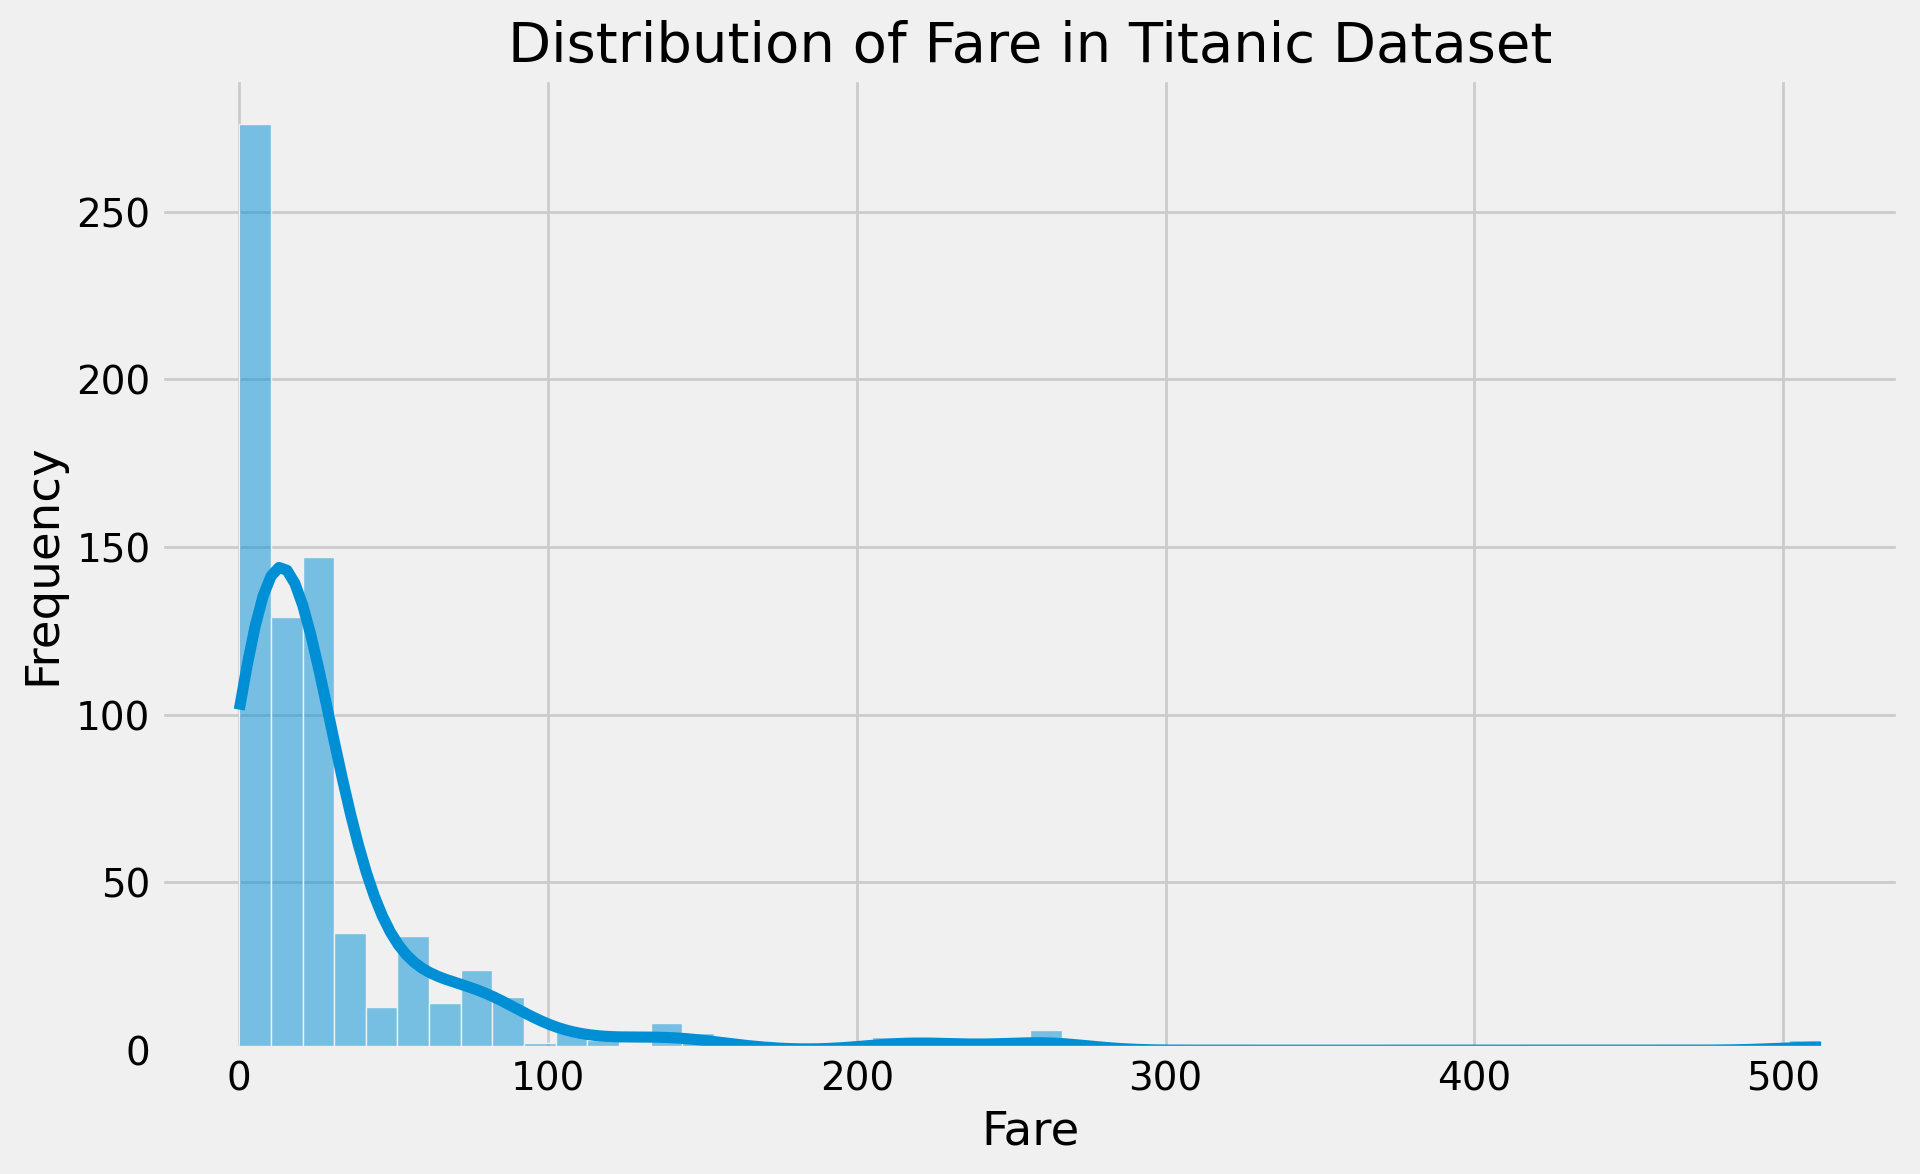

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Fare 컬럼의 분포를 시각화
plt.figure(figsize=(10, 6))
sns.histplot(enc_tr['fare'], bins=50, kde=True)
plt.title('Distribution of Fare in Titanic Dataset')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()


## Training

In [ ]:
enc_tr.isnull().sum().sum(), enc_te.isnull().sum().sum(), enc_ori_te.isnull().sum().sum()

(0, 0, 0)

In [ ]:
enc_tr.shape, enc_te.shape, enc_ori_te.shape

((732, 10), (184, 10), (393, 10))

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [ ]:
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

In [ ]:
class Objective:
    def __init__(self,x_train,y_train,seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds=2 # 학습시간을 줄이기 위해 2로 하였다. 일반적으로는 5
        self.cv = KFold(n_splits=num_folds,shuffle=True,random_state=self.seed)
    def __call__(self,trial):
        hp = {
            "max_depth" : trial.suggest_int("max_depth",2,5),
            "min_samples_split" : trial.suggest_int("min_samples_split",2,5),
            "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",5,10),
            "n_estimators" : trial.suggest_int("n_estimators",10,500,50),
            "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
        }
        model = LGBMClassifier(random_state=self.seed,**hp)
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv , scoring="roc_auc")
        return np.mean(scores)

In [ ]:
sampler = TPESampler(seed=args.random_state) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "maximize", # maximize or minimize
    sampler = sampler,
    # "verbose" : -1 # warning 제거
)
objective = Objective(enc_tr,y_tr,args.random_state)
study.optimize(objective,n_trials=100)

print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
model = LGBMClassifier(random_state=args.random_state, **study.best_params)
model.fit(enc_tr,y_tr)

pred = model.predict_proba(enc_te)[:,1]
roc_auc_score(y_te,pred)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=10 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=10 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning

0.9262531328320801

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hp = {
#     "random_state" : args.random_state
# }
# modelV0 = LGBMClassifier(**hp).fit(enc_tr, y_tr)
# # from sklearn.model_selection import cross_val_predict # 교차검증

# # y_tr = cross_val_predict(modelV0, enc_tr, y_tr, cv=5)
# print(f'{enc_tr.shape} / {y_tr.shape}')
# # modelV0.fit(enc_tr, y_tr)

## Evaluation

In [ ]:
score_tr = model.score(enc_tr, y_tr)
score_te = model.score(enc_te, y_te)

score_tr, score_te

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=10 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=10 will be ignored. Current value: num_leaves=31


(0.8647540983606558, 0.8858695652173914)

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict_proba(enc_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
print(y_pred.shape)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=10 will be ignored. Current value: num_leaves=31
(184,)
model: 0.9262531328320801


In [ ]:
ori_te_pred = model.predict_proba(enc_ori_te)[:,1]
ori_te_pred.shape

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=10 will be ignored. Current value: num_leaves=31


(393,)

In [ ]:
model.feature_importances_

array([108, 139,  64,  83,  21, 167,   0,   0,   0,   4], dtype=int32)

In [ ]:
df_feature_importances = pd.DataFrame(model.feature_importances_, enc_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(10, 2)


,index,0
0,gender_female,167
1,pclass,139
2,fare,108
3,age,83
4,sibsp,64
5,parch,21
6,embarked_S,4
7,gender_male,0
8,embarked_C,0
9,embarked_Q,0


In [ ]:
args.results.append(
    {
        'model': 'modelV6',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217'
    }
)

args.results

[{'model': 'modelV6',
  'score_tr': 0.8647540983606558,
  'score_te': 0.8858695652173914,
  'auc_te': 0.9262531328320801,
  'ori_te_pred': array([0.69774865, 0.89736343, 0.70039199, 0.11770569, 0.92018129,
         0.88037845, 0.12974481, 0.11928325, 0.63725466, 0.12509983,
         0.13145968, 0.15537326, 0.66129981, 0.69774865, 0.11928325,
         0.22137126, 0.14346698, 0.11928325, 0.11928325, 0.11928325,
         0.11770569, 0.11770569, 0.11928325, 0.09477227, 0.11928325,
         0.11770569, 0.24363179, 0.68526738, 0.25967785, 0.21816029,
         0.68797106, 0.68797106, 0.24899318, 0.25967785, 0.22137126,
         0.11770569, 0.95466893, 0.10096154, 0.25967785, 0.11770569,
         0.10096154, 0.90984166, 0.11928325, 0.91887772, 0.11770569,
         0.10096154, 0.24986288, 0.13145968, 0.10096154, 0.11150449,
         0.36008895, 0.15736562, 0.921242  , 0.11770569, 0.68797106,
         0.70039199, 0.15465316, 0.11770569, 0.11770569, 0.61128233,
         0.90984166, 0.56965846, 0.

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 18.1 MB/s eta 0:00:00


In [ ]:
!pip install scikit-image

In [ ]:
import shap
import skimage

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(enc_te)

shap_values[1].shape, enc_te.shape

((10,), (184, 10))

In [ ]:
# 첫번째 데이터만 분석
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[0,:],X_te.iloc[0,:])

In [ ]:
# 전체 데이터 분석
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_te)

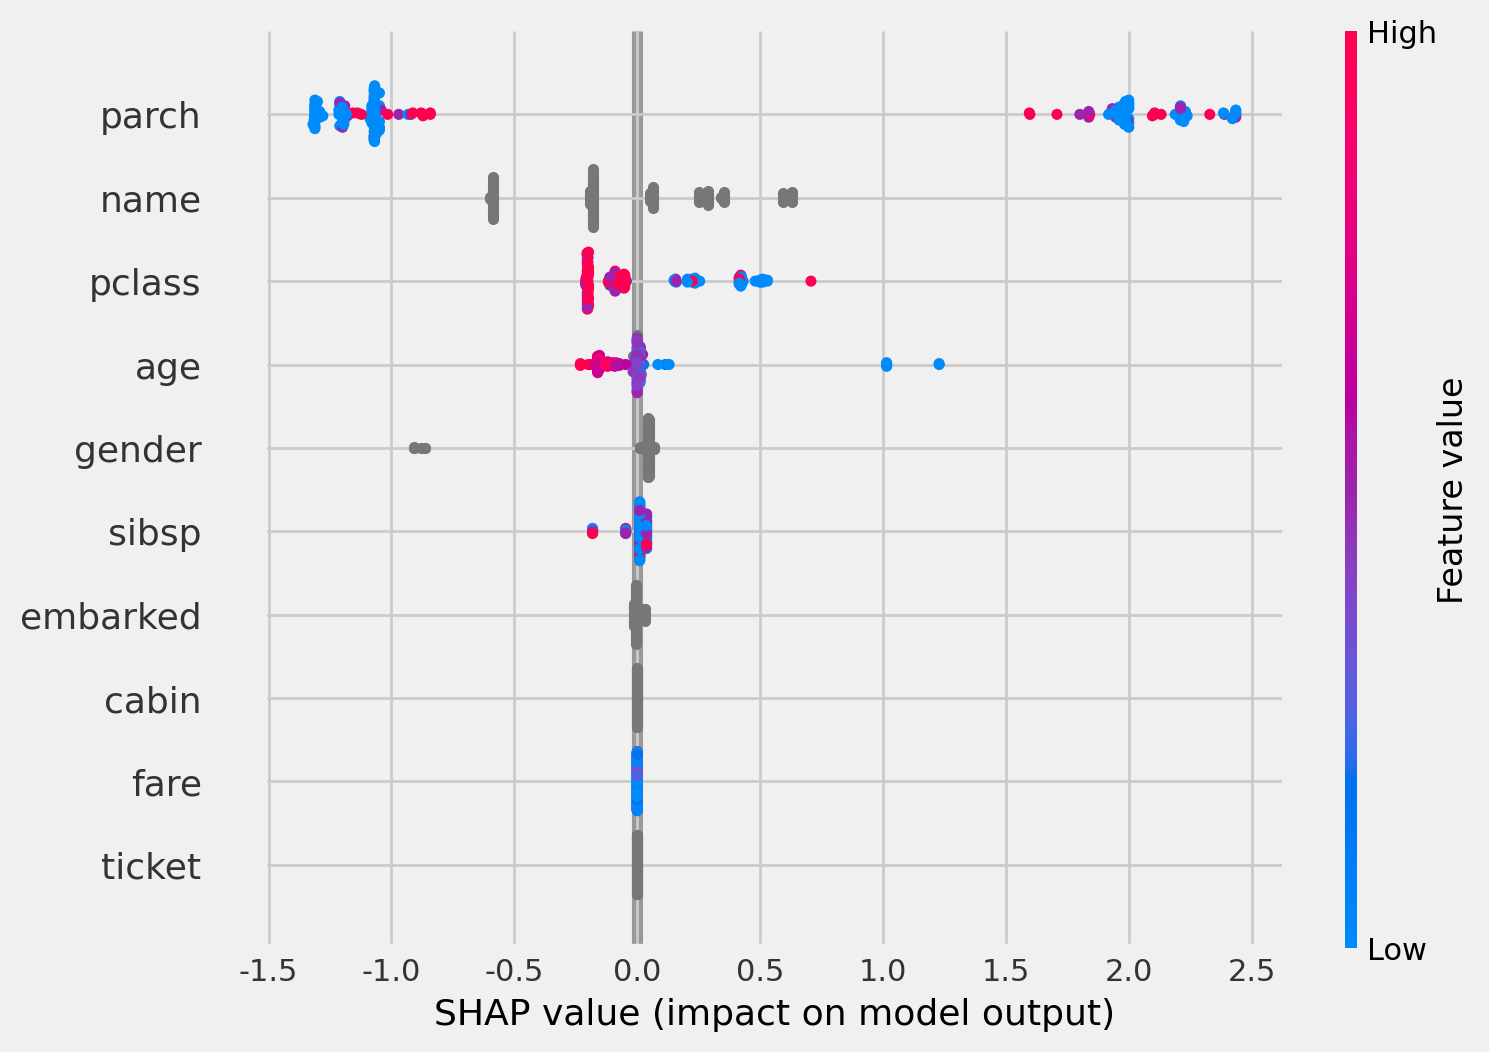

In [ ]:
shap.summary_plot(shap_values,X_te)

# Submission

In [ ]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
0,modelV6,0.863388,0.88587,0.921366,"[0.6826313200274536, 0.8954565439129303, 0.682...",10,"[gender_female, pclass, fare, age, sibsp, parc...",0217


In [ ]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [ ]:
submission['survived'] = df_results.loc[0, ['ori_te_pred']].values[0]

print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,0.682631
1,917,0.895457
2,918,0.682631
3,919,0.120917
4,920,0.907176
5,921,0.888795
6,922,0.131933
7,923,0.120917
8,924,0.662165
9,925,0.126758


In [ ]:
submission.to_csv(args.submission_csv, header=True, index=False)

Confusion Matrix:
[[0.92105263 0.07894737]
 [0.17142857 0.82857143]]


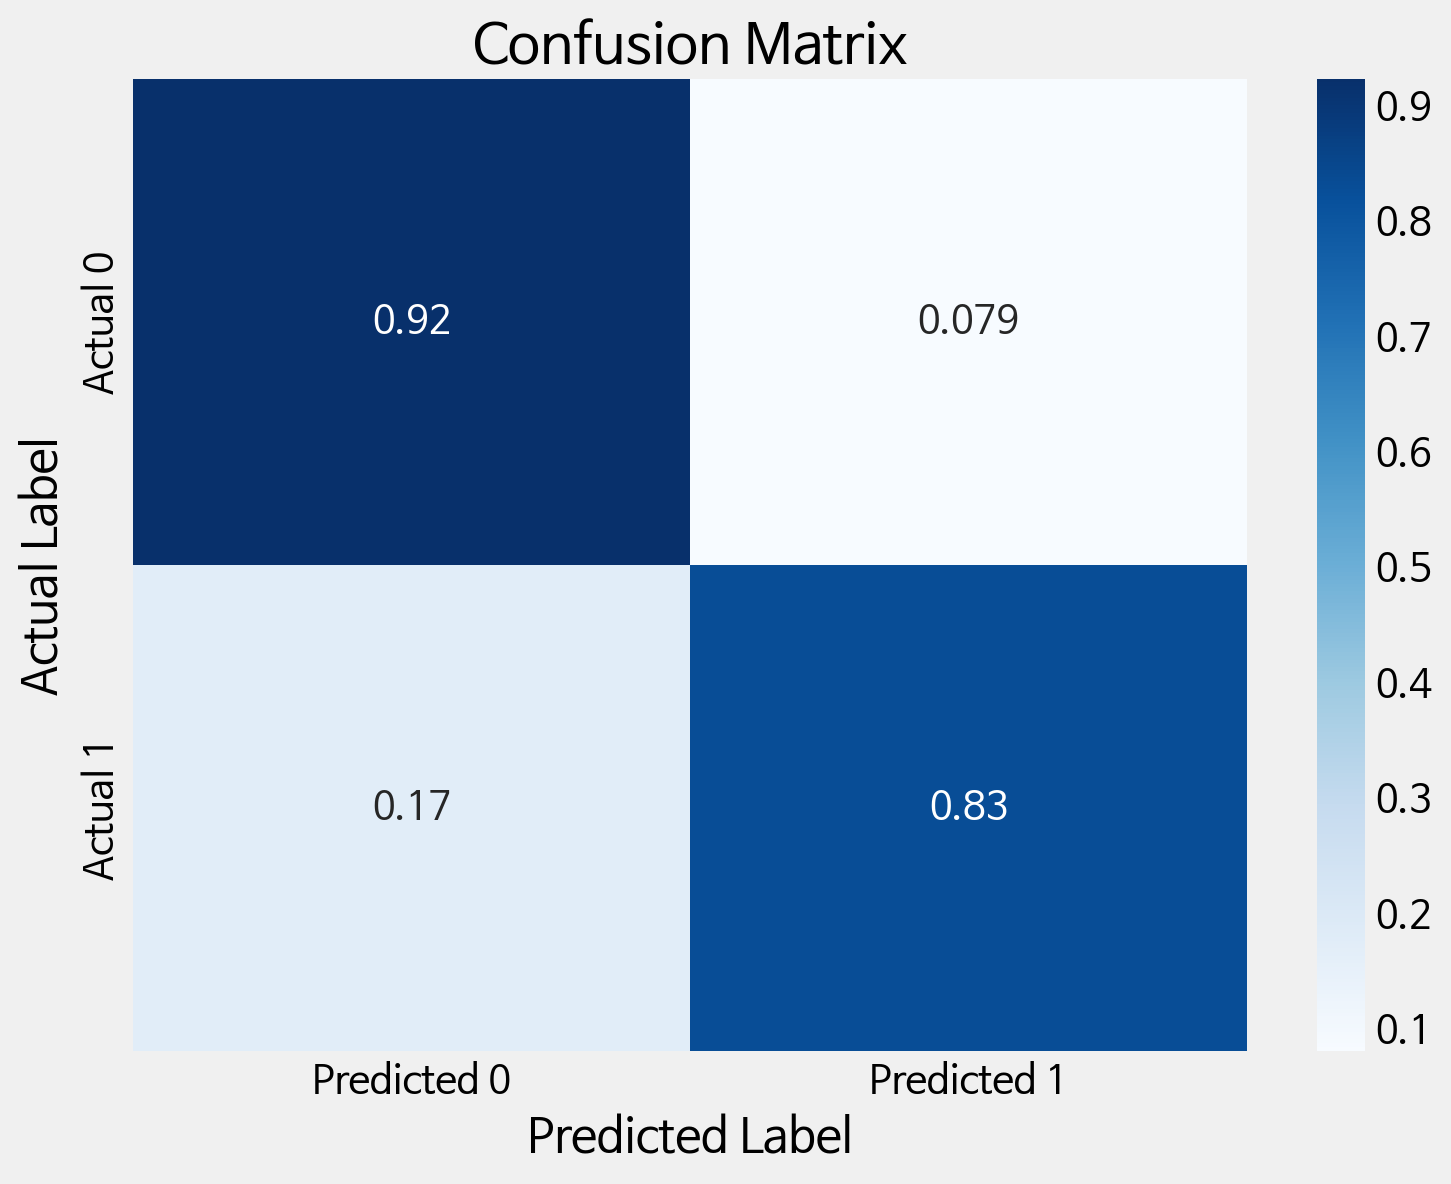

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예시 데이터 (실제 데이터로 교체하세요)
actual = y_te
predict = y_pred  # 예측값

# 임계값 설정
threshold = 0.5
predict_binary = (predict >= threshold).astype(int)

# Confusion Matrix 계산
cm = confusion_matrix(actual, predict_binary, normalize="true")

# Confusion Matrix 출력
print("Confusion Matrix:")
print(cm)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


# Save Results

In [ ]:
args.save_results

'/content/data/MyDrive/AI_study/1. Machine Learning/3. Supervised Learning/original data/result/model_results.json'

In [ ]:
df_results.columns

Index(['model', 'score_tr', 'score_te', 'auc_te', 'ori_te_pred',
       'len_features', 'feaute_importances', 'create_dt'],
      dtype='object')

In [ ]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True)

In [ ]:
df_results.to_json(args.save_results, orient="records")

In [ ]:
# 어떤 모델이 일을 잘했는지 확인 가능
df_results.head()

,model,score_tr,score_te,auc_te,len_features,feaute_importances,create_dt
0,modelV5,0.864754,0.88587,0.927882,10,"[gender_female, pclass, fare, age, sibsp, parc...",0217


In [ ]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

load_results

[{'model': 'modelV5',
  'score_tr': 0.8647540984,
  'score_te': 0.8858695652,
  'auc_te': 0.9278822055,
  'len_features': 10,
  'feaute_importances': ['gender_female',
   'pclass',
   'fare',
   'age',
   'sibsp',
   'parch',
   'embarked_S',
   'gender_male',
   'embarked_C',
   'embarked_Q'],
  'create_dt': '0217'}]

Confusion Matrix:
[[0.92105263 0.07894737]
 [0.17142857 0.82857143]]


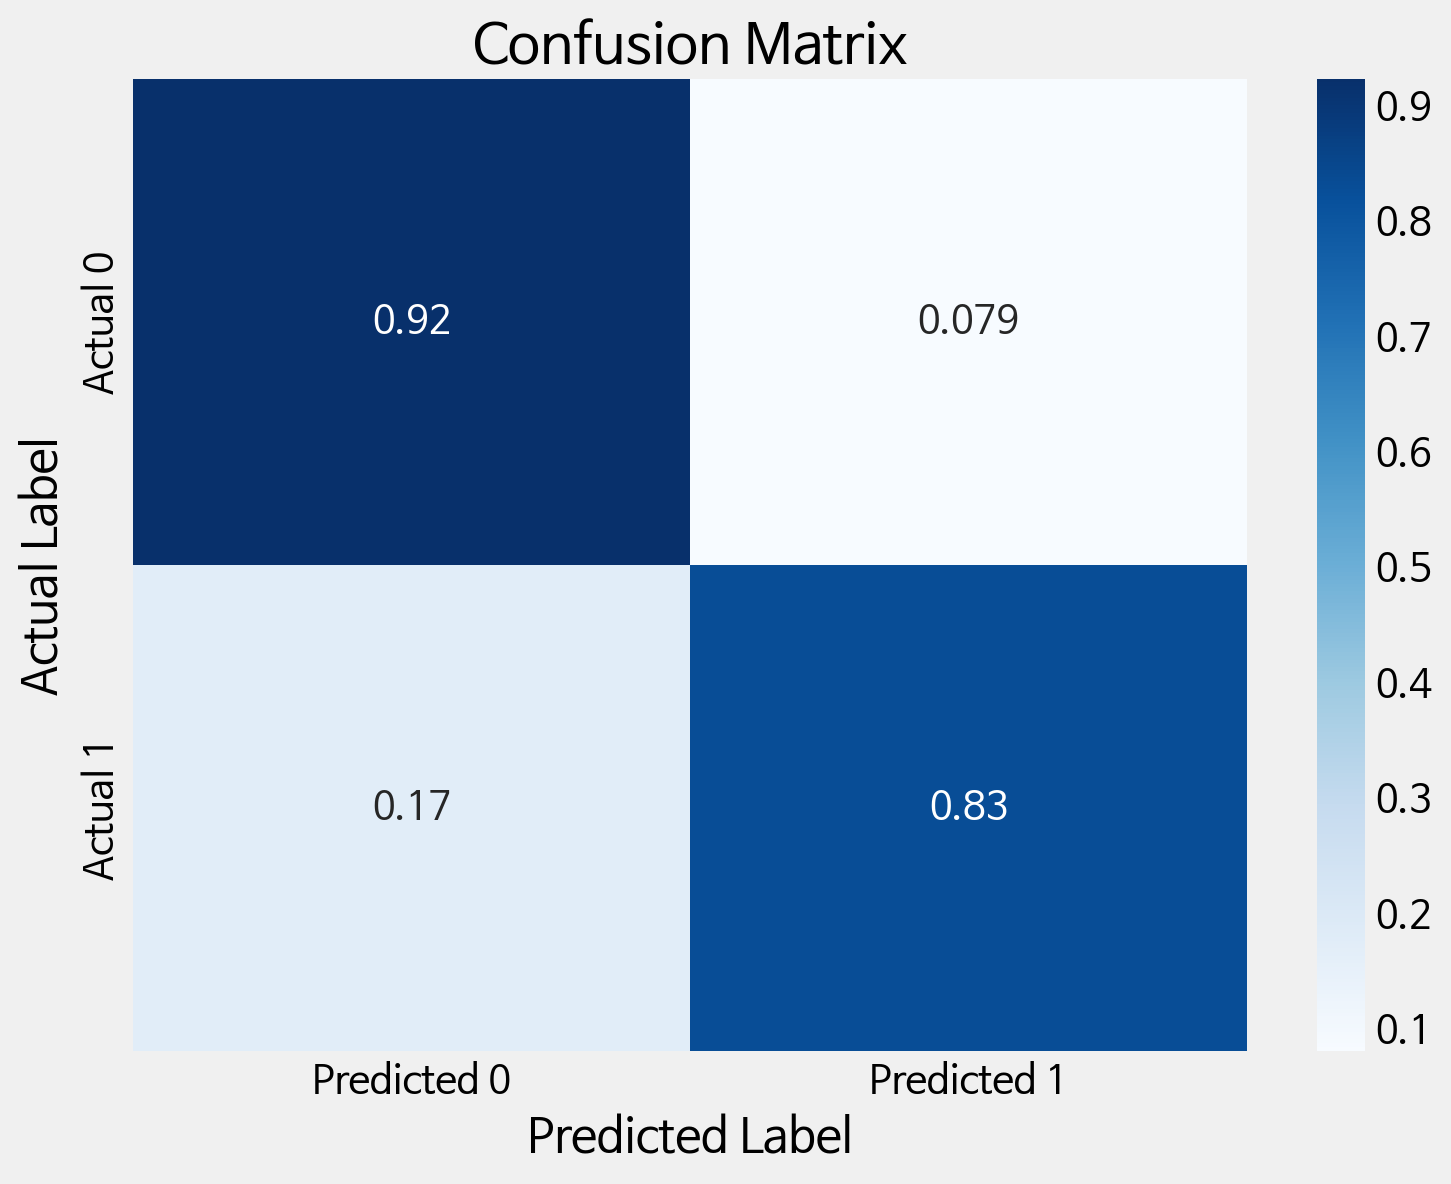

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예시 데이터 (실제 데이터로 교체하세요)
actual = y_te
predict = y_pred  # 예측값

# 임계값 설정
threshold = 0.5
predict_binary = (predict >= threshold).astype(int)

# Confusion Matrix 계산
cm = confusion_matrix(actual, predict_binary, normalize="true")

# Confusion Matrix 출력
print("Confusion Matrix:")
print(cm)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()
